<a href="https://colab.research.google.com/github/Sandeshmalla7/machine_learning/blob/main/HousePred_intern_Sandesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeshmalla7","key":"9361b404d2cfd8a94ef747033eac47c4"}'}

In [3]:
# Create the .kaggle folder
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle folder
!cp kaggle.json ~/.kaggle/

# Secure the file by setting permissions (only your account can access it)
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


100% 199k/199k [00:00<00:00, 384kB/s]
100% 199k/199k [00:00<00:00, 384kB/s]


In [5]:
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
with open("/content/data_description.txt", "r") as f:
    for i in range(20):
        print(f.readline().strip())


MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.


In [7]:
submission = pd.read_csv('/content/sample_submission.csv')

print(submission.head())


     Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977


In [8]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Display dataset overview
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
train_df.head()


Train Data Shape: (1460, 81)
Test Data Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
test_IDs = test_df['Id']

train_df.drop(columns=['Id'], inplace=True)
test_df.drop(columns=['Id'], inplace=True)

print(f"Train Shape Before Preprocessing: {train_df.shape}")
print(f"Test Shape Before Preprocessing: {test_df.shape}")

Train Shape Before Preprocessing: (1460, 80)
Test Shape Before Preprocessing: (1459, 79)


In [10]:
threshold = 0.3 * train_df.shape[0]
cols_to_drop = train_df.isnull().sum()[train_df.isnull().sum() > threshold].index.tolist()
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)


In [12]:
for col in train_df.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'SalePrice':
        train_df[col].fillna(train_df[col].median(), inplace=True)

for col in test_df.select_dtypes(include=['int64', 'float64']).columns:
    test_df[col].fillna(test_df[col].median(), inplace=True)

print("✅ Missing numeric values filled successfully!")


✅ Missing numeric values filled successfully!


In [13]:
print("Missing Values After Fix (Train):", train_df.isnull().sum().sum())
print("Missing Values After Fix (Test):", test_df.isnull().sum().sum())


Missing Values After Fix (Train): 512
Missing Values After Fix (Test): 539


In [14]:
# Fill missing categorical values with 'None' (same strategy for both)
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col].fillna('None', inplace=True)
    test_df[col].fillna('None', inplace=True)

# Verify missing values
print("Missing Values After Cleaning (Train):", train_df.isnull().sum().sum())
print("Missing Values After Cleaning (Test):", test_df.isnull().sum().sum())

Missing Values After Cleaning (Train): 0
Missing Values After Cleaning (Test): 0


In [16]:
# Apply same feature engineering to both train and test
for df in [train_df, test_df]:
    df['TotalArea'] = df['GrLivArea'] + df['GarageArea'] + df['TotalBsmtSF']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodeledAge'] = df['YrSold'] - df['YearRemodAdd']
    df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + df['BsmtHalfBath']
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']

In [17]:
# Drop irrelevant columns that exist in both datasets
cols_to_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd']
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

In [18]:
# Print new shapes
print(f"Train Shape After Feature Engineering: {train_df.shape}")
print(f"Test Shape After Feature Engineering: {test_df.shape}")

Train Shape After Feature Engineering: (1460, 79)
Test Shape After Feature Engineering: (1459, 78)


In [23]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
cat_features = train_df.select_dtypes(include=['object']).columns

# OneHotEncoding categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = pd.DataFrame(encoder.fit_transform(train_df[cat_features]))
encoded_test = pd.DataFrame(encoder.transform(test_df[cat_features]))

# Assign column names
encoded_train.columns = encoder.get_feature_names_out(cat_features)
encoded_test.columns = encoder.get_feature_names_out(cat_features)



In [24]:
import sklearn
from sklearn.preprocessing import OneHotEncoder

print("Scikit-Learn Version:", sklearn.__version__)

if int(sklearn.__version__.split(".")[1]) >= 2:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

print("✅ OneHotEncoder initialized successfully!")


Scikit-Learn Version: 1.6.1
✅ OneHotEncoder initialized successfully!


In [25]:
train_df.drop(columns=cat_features, inplace=True)
test_df.drop(columns=cat_features, inplace=True)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df = pd.concat([train_df, encoded_train], axis=1)
test_df = pd.concat([test_df, encoded_test], axis=1)

print(f"Final Train Shape: {train_df.shape}")
print(f"Final Test Shape: {test_df.shape}")

assert train_df.shape[1] - 1 == test_df.shape[1], "Mismatch in train & test features!"


Final Train Shape: (1460, 282)
Final Test Shape: (1459, 281)


In [26]:
X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

assert X.shape[1] == test_df.shape[1], "Train and test features do not match!"

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 17995.05980002003
Mean Squared Error (MSE): 953104606.4542487
R² Score: 0.8757413204198297


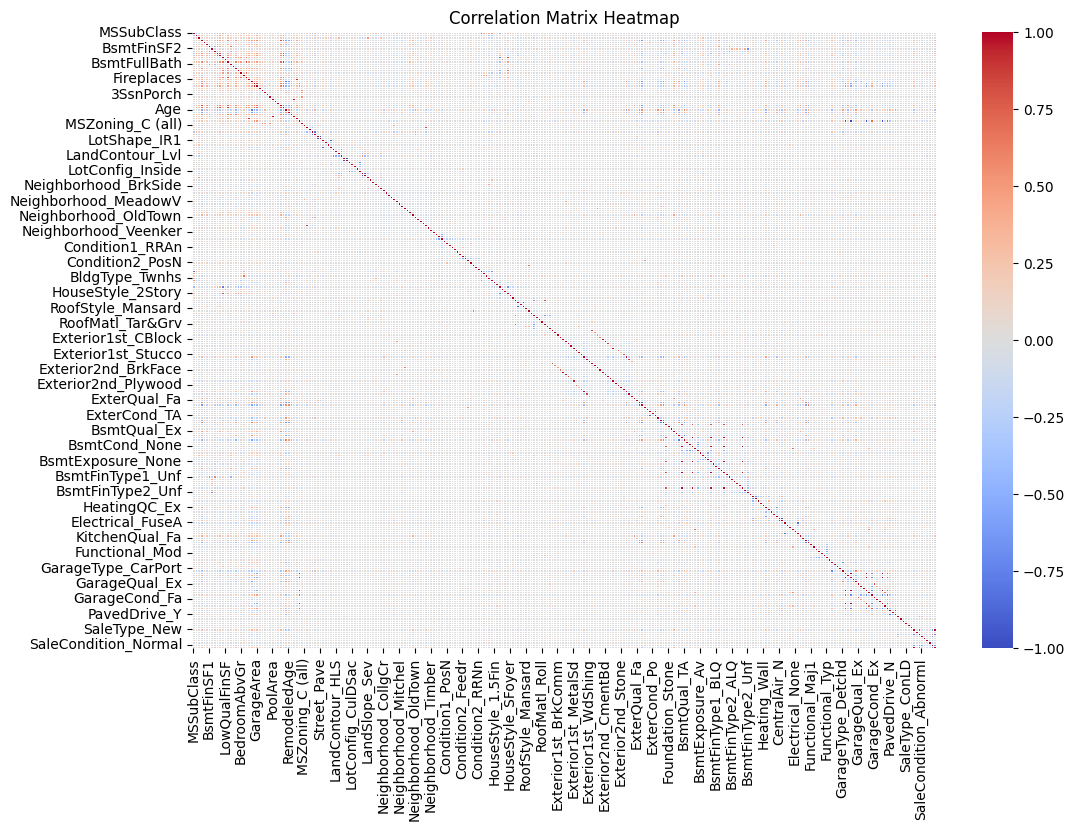

In [30]:

corr_matrix = train_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


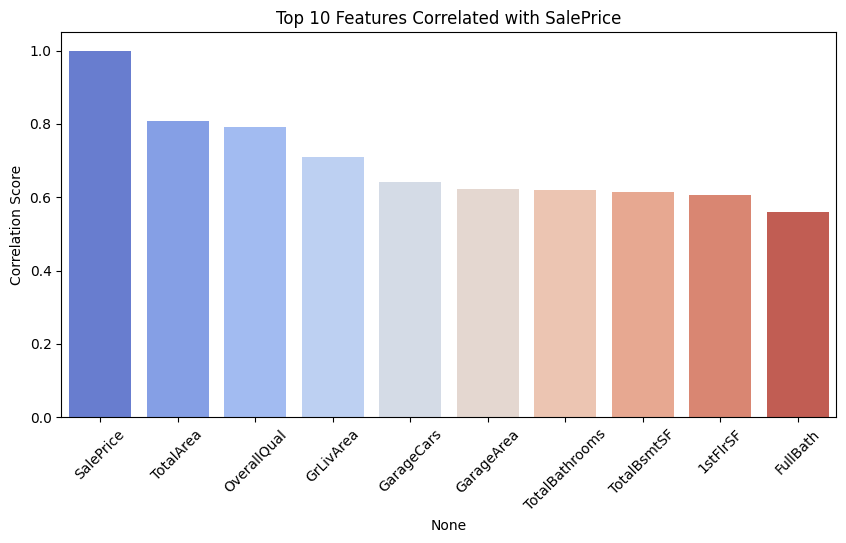

In [31]:
top_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_corr_features.index, y=top_corr_features.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Features Correlated with SalePrice")
plt.ylabel("Correlation Score")
plt.show()


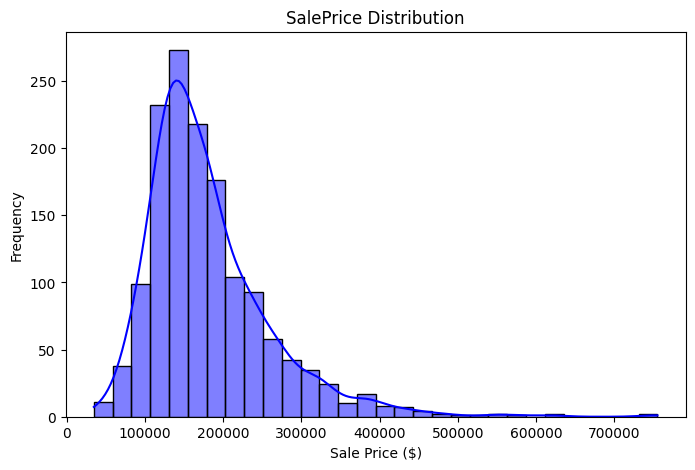

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], bins=30, kde=True, color='blue')
plt.title("SalePrice Distribution")
plt.xlabel("Sale Price ($)")
plt.ylabel("Frequency")
plt.show()


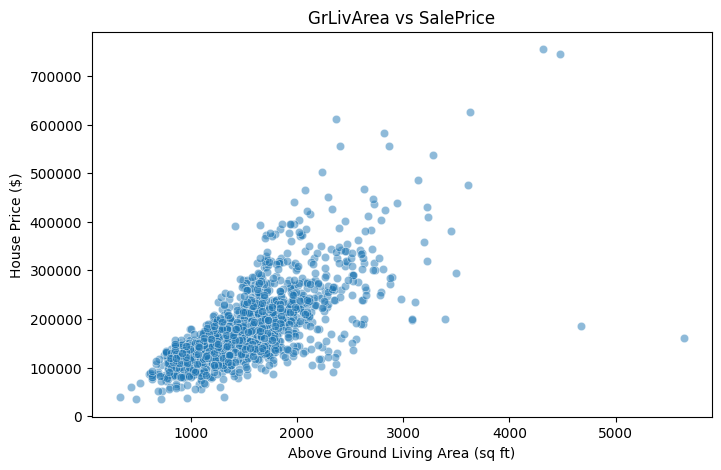

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], alpha=0.5)
plt.title("GrLivArea vs SalePrice")
plt.xlabel("Above Ground Living Area (sq ft)")
plt.ylabel("House Price ($)")
plt.show()


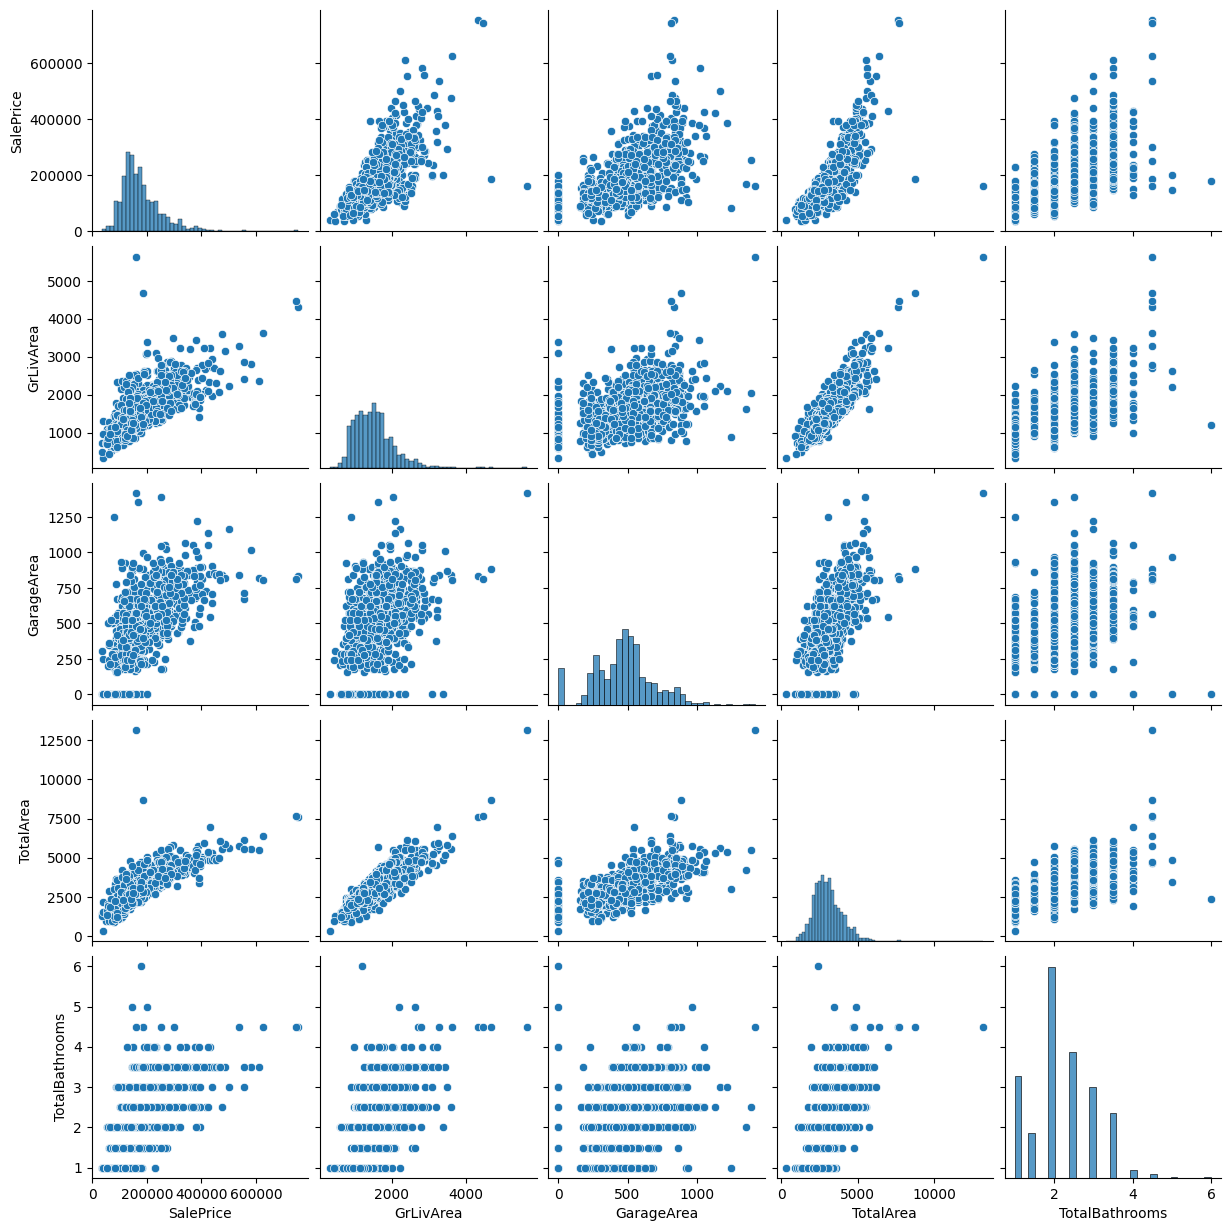

In [35]:
key_features = ['SalePrice', 'GrLivArea', 'GarageArea', 'TotalArea', 'TotalBathrooms']
sns.pairplot(train_df[key_features])
plt.show()



In [36]:
import joblib

joblib.dump(model, 'house_price_model.pkl')

joblib.dump(encoder, 'encoder.pkl')

print("Model and Encoder Saved Successfully!")


Model and Encoder Saved Successfully!


In [37]:
test_predictions = model.predict(test_df)


In [38]:
# Load sample submission file
submission = pd.read_csv('/content/sample_submission.csv')

# Assign predicted values
submission['SalePrice'] = test_predictions

# Save submission file
submission.to_csv('final_submission.csv', index=False)

# Download file
from google.colab import files
files.download('final_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>